# Visualization of Semantic Segmentation on Validation Dataset

This notebook provides visualization for the model's predictions and ground truth on the Validation dataset (specifically `FS_LostFound_full` subset).
It performs semantic inference.

In [2]:
import os
# Workaround for Windows OpenMP runtime conflict
os.environ.setdefault("KMP_DUPLICATE_LIB_OK", "TRUE")

import glob
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import yaml
import importlib
from torch.utils.data import Dataset, DataLoader
import warnings

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


## 1. Load Model
We load the model using the same configuration as in `inference.ipynb`.

In [3]:
# Configuration paths (Adjust if necessary)
config_path = "eomt/configs/dinov2/cityscapes/semantic/eomt_base_640.yaml"
# Checkpoint path from inference.ipynb
ckpt_path = "trained_eomt/eomt_cityscapes.bin"

# Ensure imports work by adding project root to path if needed
import sys
if os.path.abspath('.') not in sys.path:
    sys.path.append(os.path.abspath('.'))
if os.path.abspath('eomt') not in sys.path:
    sys.path.append(os.path.abspath('eomt'))

from eomt.models.vit import ViT
from eomt.models.eomt import EoMT
from eomt.training.mask_classification_semantic import MaskClassificationSemantic

# Load Config
if not os.path.exists(config_path):
    # Try looking in eomt folder if running from root
    if os.path.exists(os.path.join("eomt", config_path)):
         config_path = os.path.join("eomt", config_path)
    else:
         print(f"Warning: Config path {config_path} not found.")

with open(config_path, "r") as f:
    config = yaml.safe_load(f)

# Initialize Model Architecture
# We manually construct it as in inference.ipynb to avoid complex dynamic imports issues if paths differ

warnings.filterwarnings("ignore")

print("Loading model...")
# 1. Encoder
encoder = ViT(
    img_size=(1024, 1024),
    patch_size=16,
    backbone_name="vit_base_patch14_reg4_dinov2",
    ckpt_path=None,
)

# 2. Network (EoMT)
network = EoMT(
    encoder=encoder,
    num_classes=19, # Cityscapes classes
    num_q=100,
    num_blocks=3,
    masked_attn_enabled=False,
)

# 3. Lightning Module
model = MaskClassificationSemantic(
    network=network,
    img_size=(1024, 1024),
    num_classes=19,
    attn_mask_annealing_enabled=False,
    attn_mask_annealing_start_steps=None,
    attn_mask_annealing_end_steps=None,
    ckpt_path=ckpt_path,
    delta_weights=False,
    load_ckpt_class_head=False,
)

finetuned_model = MaskClassificationSemantic(
    network=network,
    img_size=(1024, 1024),
    num_classes=19,
    attn_mask_annealing_enabled=False,
    attn_mask_annealing_start_steps=None,
    attn_mask_annealing_end_steps=None,
    ckpt_path=ckpt_path,
    delta_weights=False,
    load_ckpt_class_head=False,
)

model.eval()
model.to(device)
finetuned_model.eval()
finetuned_model.to(device)
print("Model loaded successfully.")

c:\Users\maimi\anaconda3\envs\eomt\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Loading model...
Model loaded successfully.


## 2. Define Validation Dataset Loader
We'll load images from `Validation_Dataset/FS_LostFound_full`.

In [4]:
class ValidationDataset(Dataset):
    def __init__(self, root_dir):
        self.root_dir = root_dir
        self.images_dir = os.path.join(root_dir, 'images')
        self.labels_dir = os.path.join(root_dir, 'labels_masks')
        
        self.image_files = sorted(glob.glob(os.path.join(self.images_dir, '*.png')))
        self.label_files = sorted(glob.glob(os.path.join(self.labels_dir, '*.png')))
        
        # Simple check
        if len(self.image_files) != len(self.label_files):
            print(f"Warning: Mismatch in number of images ({len(self.image_files)}) and labels ({len(self.label_files)})")

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = self.image_files[idx]
        label_path = self.label_files[idx]
        
        # Load Image
        img = Image.open(img_path).convert('RGB')
        img_np = np.array(img)
        # Convert to tensor (C, H, W). Keep as uint8 for compatibility with PIL in window_imgs_semantic
        # Do NOT convert to float here because window_imgs_semantic expects byte tensor for PIL conversion
        img_tensor = torch.from_numpy(img_np).permute(2, 0, 1)
        
        # Load Label (Mask)
        label = Image.open(label_path)
        label_np = np.array(label)
        label_tensor = torch.from_numpy(label_np).long()
        
        return img_tensor, label_tensor, os.path.basename(img_path)

# Set path to dataset
val_dataset_path = r"Validation_Dataset/FS_LostFound_full" # Using relative path assuming notebook is in project root
if not os.path.exists(val_dataset_path):
    print(f"Path not found: {val_dataset_path}. Please check your current working directory.")
    print(f"Current PWD: {os.getcwd()}")

dataset = ValidationDataset(val_dataset_path)
dataloader = DataLoader(dataset, batch_size=1, shuffle=False)
print(f"Found {len(dataset)} images in {val_dataset_path}")

Found 100 images in Validation_Dataset/FS_LostFound_full


## 3. Inference and Visualization Helper
We implement the semantic inference logic.

In [5]:
def infer_semantic(model, img_tensor):
    """
    Perform semantic inference on a single image tensor.
    Args:
        model: loaded MaskClassificationSemantic model
        img_tensor: tensor of shape (C, H, W) (uint8)
    Returns:
        logits: per-pixel logits (C_classes, H, W)
        pred_mask: argmax prediction (H, W)
    """
    model.eval()
    with torch.no_grad():
        # Add batch dimension if needed
        if img_tensor.dim() == 3:
            imgs = img_tensor.unsqueeze(0).to(device)
        else:
            imgs = img_tensor.to(device)
            
        img_sizes = [img.shape[-2:] for img in imgs]
        
        # 1. Windowing / Cropping
        crops, origins = model.window_imgs_semantic(imgs)
        
        # 2. Forward pass
        mask_logits_per_layer, class_logits_per_layer = model(crops)
        
        # 3. Use the last layer output (usually sufficient for inference)
        mask_logits = mask_logits_per_layer[-1]
        class_logits = class_logits_per_layer[-1]
        
        # 4. Interpolate and combine
        mask_logits = F.interpolate(mask_logits, model.img_size, mode="bilinear")
        crop_logits = model.to_per_pixel_logits_semantic(mask_logits, class_logits)
        
        # 5. Revert to original image size
        logits = model.revert_window_logits_semantic(crop_logits, origins, img_sizes)
        
        # logits is a list of tensors, take the first one since we used batch_size=1
        final_logits = logits[0]
        probs = F.softmax(final_logits, dim=0)
        pred_mask = 1.0 - torch.max(probs, dim=0).values
        
        return final_logits.cpu(), pred_mask.cpu()

def visualize_result(img_tensor, target_mask, pred_mask, img_name):
    """
    Visualize the image, ground truth, and prediction side-by-side.
    """
    img_np = img_tensor.permute(1, 2, 0).numpy().astype(np.uint8)
    target_np = target_mask.numpy()
    pred_np = pred_mask.numpy()
    
    # Setup plots
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    
    # 1. Original Image
    axes[0].imshow(img_np)
    axes[0].set_title(f"Image: {img_name}")
    axes[0].axis('off')
    
    # 2. Ground Truth
    # Using a colormap for better visualization
    axes[1].imshow(target_np, cmap='tab20', interpolation='nearest')
    axes[1].set_title("Ground Truth")
    axes[1].axis('off')
    
    # 3. Prediction
    axes[2].imshow(pred_np, cmap='tab20', interpolation='nearest')
    axes[2].set_title("Prediction (Semantic)")
    axes[2].axis('off')
    
    plt.tight_layout()
    plt.show()

## 4. Run Visualization
Run on a few samples from the dataset.

Processing 0.png...


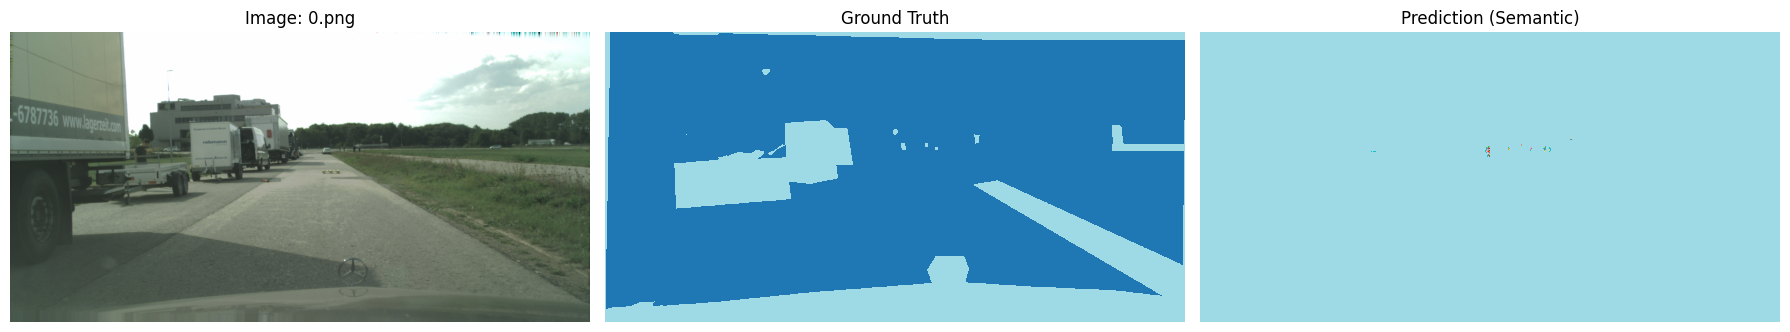

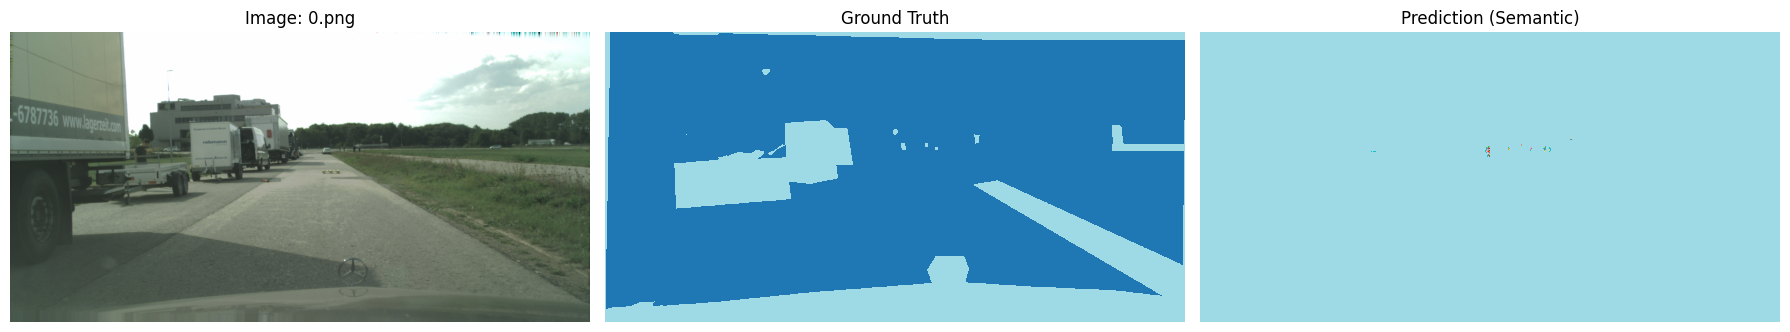

Processing 1.png...


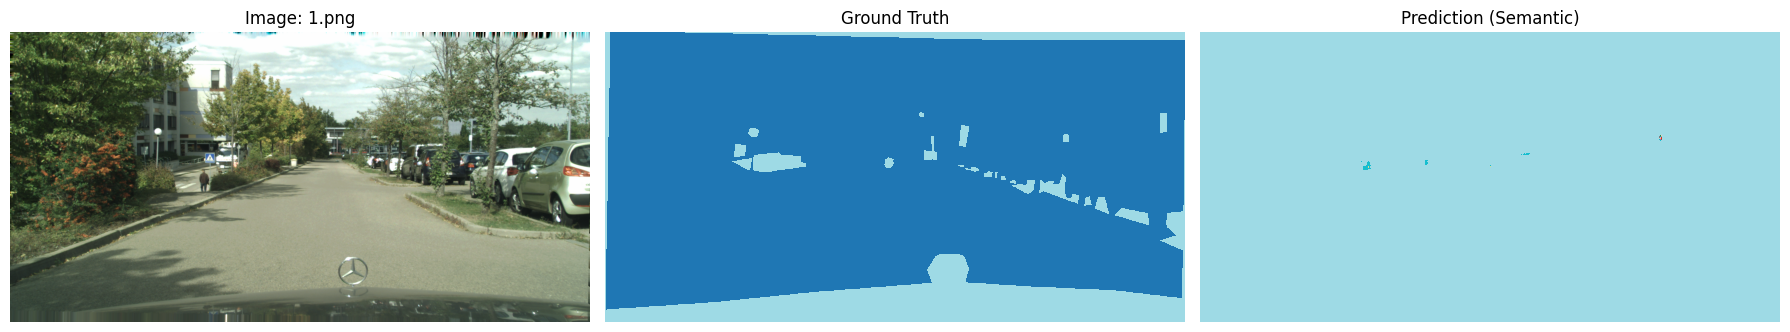

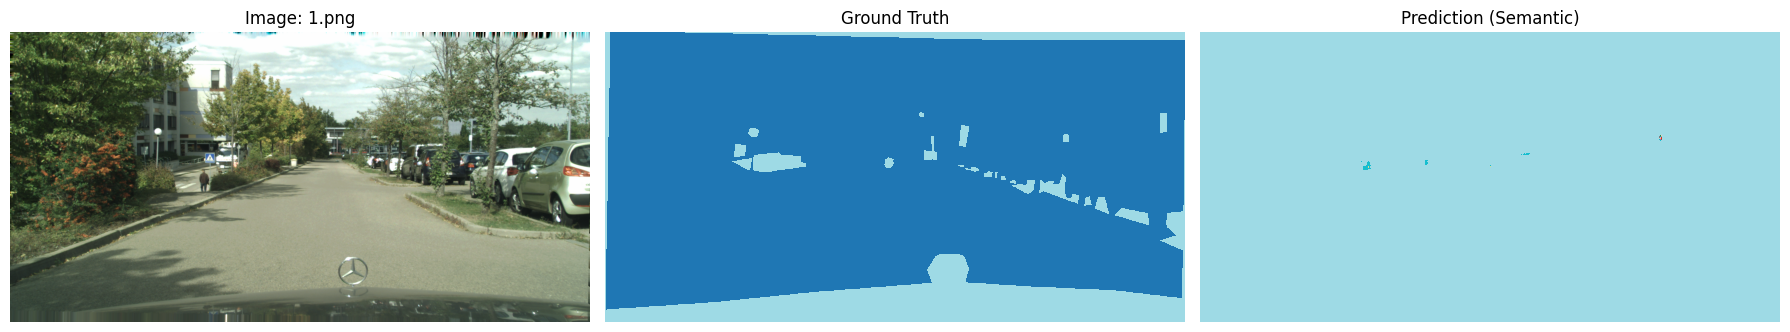

Processing 10.png...


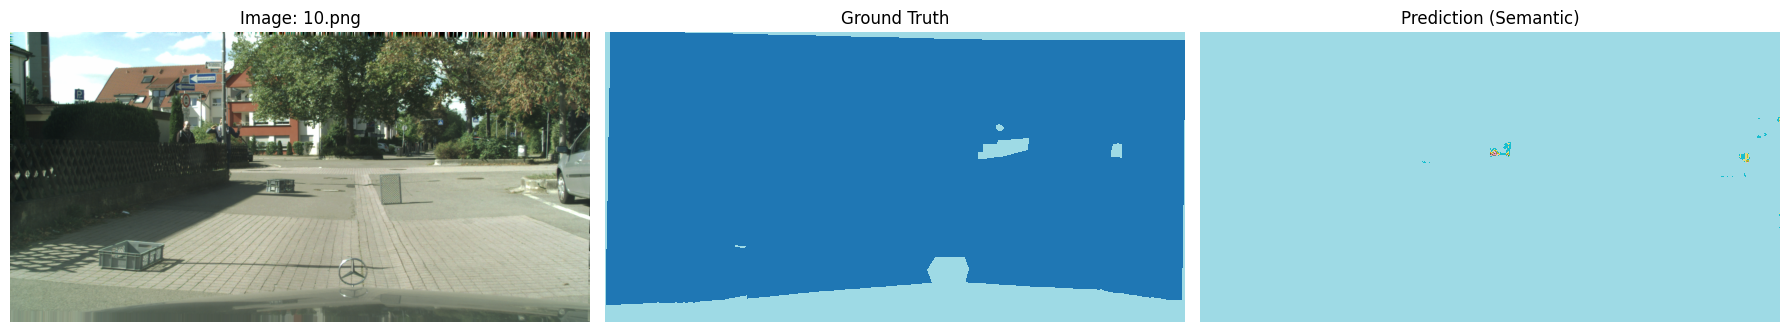

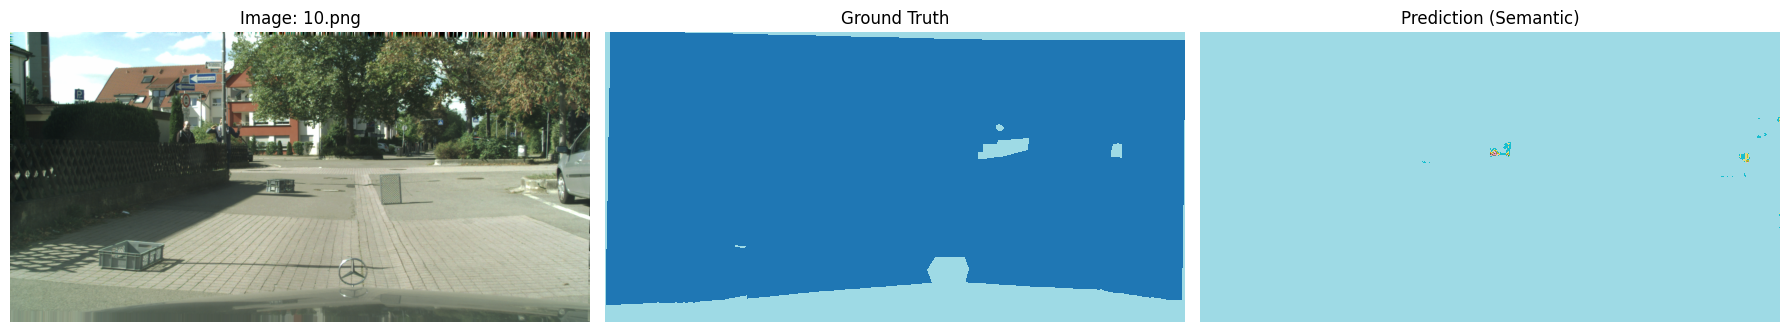

Processing 11.png...


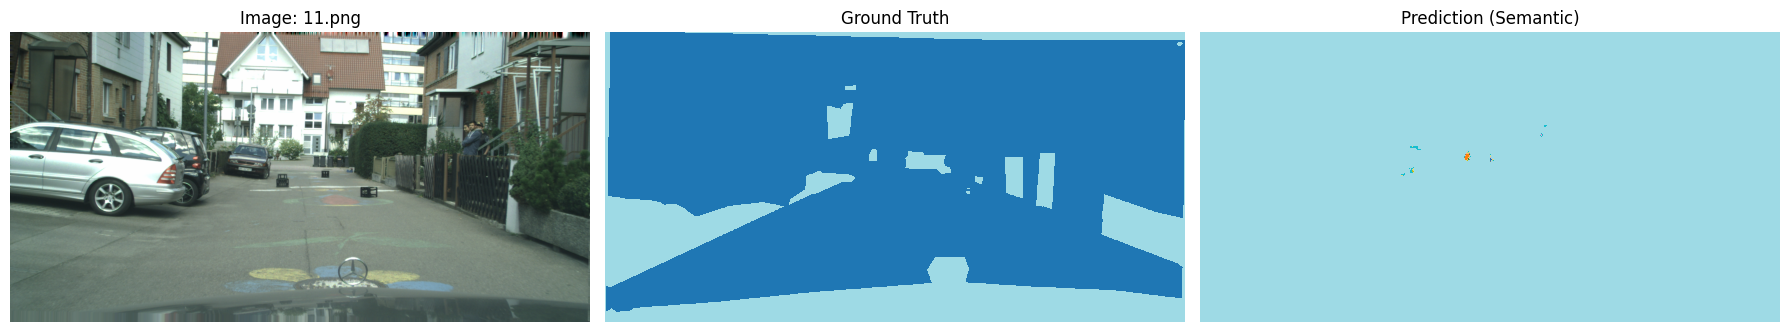

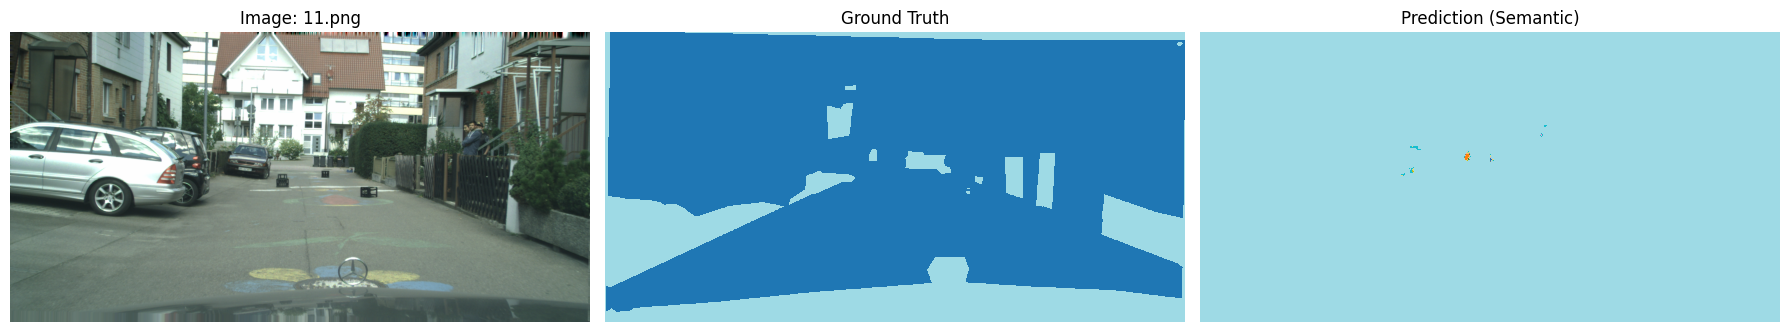

Processing 12.png...


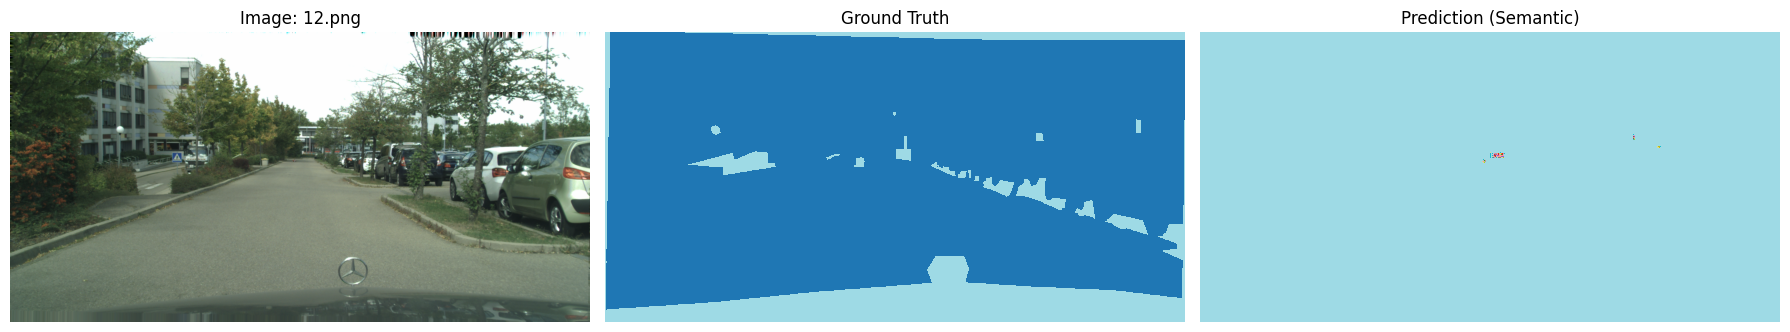

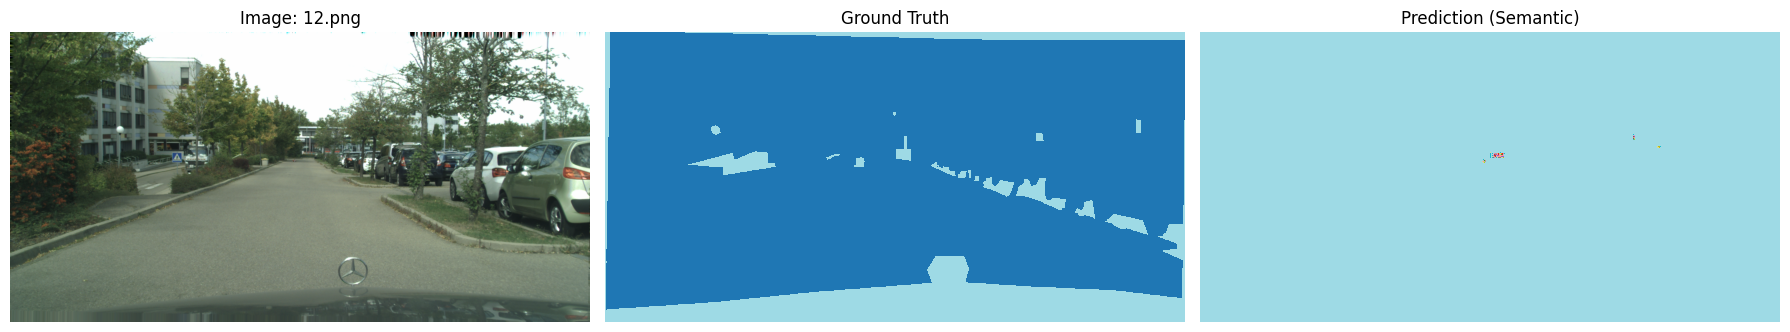

In [6]:
# Config: How many images to show
num_samples = 5

for i, (img_t, label_t, name_list) in enumerate(dataloader):
    if i >= num_samples:
        break
        
    img_name = name_list[0]
    print(f"Processing {img_name}...")
    
    # Run inference
    logits, pred_mask = infer_semantic(model, img_t[0]) # img_t has batch dim from dataloader
    
    # Visualize
    visualize_result(img_t[0], label_t[0], pred_mask, img_name)

    # Run inference
    logits, pred_mask = infer_semantic(finetuned_model, img_t[0]) # img_t has batch dim from dataloader
    
    # Visualize
    visualize_result(img_t[0], label_t[0], pred_mask, img_name)